In [1]:
%load_ext autoreload
%autoreload 2 
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
import scipy.stats as stats

In [2]:
# from data_compilation import call_all_symbols
# from data_cleaning import full_clean

In [3]:
# symbol_list = ['SLV', 'SIL', 'GLD', 'GDX', 'DJI']

In [4]:
# df = call_all_symbols(symbol_list)

In [5]:
from data_cleaning import full_clean

In [6]:
#Cleaning data
df_clean = full_clean()

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


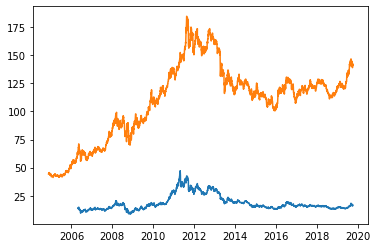

In [7]:
df_clean_SLV = df_clean.loc[df_clean['symbol'] == 'SLV']
df_clean_GLD = df_clean.loc[df_clean['symbol'] == 'GLD']
plt.plot(df_clean_SLV['date'], df_clean_SLV['close'])
plt.plot(df_clean_GLD['date'], df_clean_GLD['close']);

In [8]:
df_clean['daily_movement'] = (df_clean.open-df_clean.close)*100/df_clean.open
df_clean.head()

,date,open,high,low,close,volume,symbol,daily_movement
0,2019-10-08,16.60,16.66,16.49,16.61,19326217.0,SLV,-0.060241
1,2019-10-07,16.38,16.46,16.28,16.30,8359926.0,SLV,0.488400
2,2019-10-04,16.30,16.46,16.25,16.41,17200800.0,SLV,-0.674847
3,2019-10-03,16.38,16.65,16.37,16.43,24412700.0,SLV,-0.305250
4,2019-10-02,16.33,16.54,16.27,16.43,21300800.0,SLV,-0.612370


In [9]:
df_clean_SLV = df_clean.loc[df_clean['symbol'] == 'SLV'][['date','symbol','open','close','daily_movement']]
df_clean_GLD = df_clean.loc[df_clean['symbol'] == 'GLD'][['date','symbol','open','close','daily_movement']]
df_clean_GLD.date.isin(df_clean_SLV.date).value_counts()

True     3385
False     362
Name: date, dtype: int64

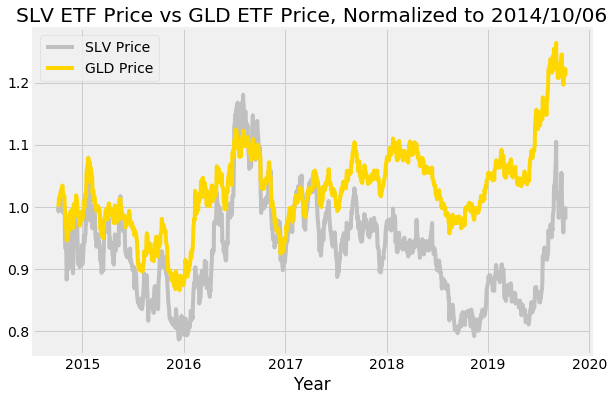

In [10]:
#Normalized to 2014-10-06
SLV_scaled = df_clean_SLV.loc[df_clean_SLV.date>='2014-10-06'].copy()
GLD_scaled = df_clean_GLD.loc[df_clean_GLD.date>='2014-10-06'].copy()

SLV_scaled['scale'] = SLV_scaled['close']/SLV_scaled.iloc[-1]['close']
GLD_scaled['scale'] = GLD_scaled['close']/GLD_scaled.iloc[-1]['close']

SLV_scaled['pct_change'] = SLV_scaled.close.pct_change()*100
GLD_scaled['pct_change'] = GLD_scaled.close.pct_change()*100
SLV_scaled = SLV_scaled.fillna(value=0)
GLD_scaled = GLD_scaled.fillna(value=0)

plt.figure(figsize = (10,6))
plt.style.use('fivethirtyeight')
plt.plot(SLV_scaled['date'], SLV_scaled['scale'],label='SLV Price',c='silver')
plt.plot(GLD_scaled['date'], GLD_scaled['scale'],label='GLD Price',c='gold')
plt.title("SLV ETF Price vs GLD ETF Price, Normalized to 2014/10/06")
plt.xlabel('Year')
plt.legend()

plt.savefig('img/SLV_vs_GLD_5yrs')


### Comparing daily movements : SLV vs GLD
#### $H{0}$: daily_movement_SLV - daily_movement_GLD = 0
#### $H{a}$: daily_movement_SLV - daily_movement_GLD > 0

In [11]:
df_slv_vs_gld = pd.merge(SLV_scaled,
                         GLD_scaled,
                         how='left',
                         on='date',
                         suffixes=('_SLV', '_GLD'))

df_slv_vs_gld['delta'] = df_slv_vs_gld['daily_movement_SLV']-df_slv_vs_gld['daily_movement_GLD']
df_slv_vs_gld['delta2'] = df_slv_vs_gld['pct_change_SLV']-df_slv_vs_gld['pct_change_GLD']
print(df_slv_vs_gld.shape)
df_slv_vs_gld.head()

(1261, 15)


,date,symbol_SLV,open_SLV,close_SLV,daily_movement_SLV,scale_SLV,pct_change_SLV,symbol_GLD,open_GLD,close_GLD,daily_movement_GLD,scale_GLD,pct_change_GLD,delta,delta2
0,2019-10-08,SLV,16.60,16.61,-0.060241,1.000602,0.000000,GLD,142.03,141.95,0.056326,1.223391,0.000000,-0.116567,0.000000
1,2019-10-07,SLV,16.38,16.30,0.488400,0.981928,-1.866346,GLD,141.16,140.69,0.332956,1.212531,-0.887636,0.155445,-0.978709
2,2019-10-04,SLV,16.30,16.41,-0.674847,0.988554,0.674847,GLD,141.48,141.90,-0.296862,1.222960,0.860047,-0.377985,-0.185200
3,2019-10-03,SLV,16.38,16.43,-0.305250,0.989759,0.121877,GLD,141.36,141.90,-0.382003,1.222960,0.000000,0.076753,0.121877
4,2019-10-02,SLV,16.33,16.43,-0.612370,0.989759,0.000000,GLD,140.79,141.26,-0.333831,1.217444,-0.451022,-0.278539,0.451022


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

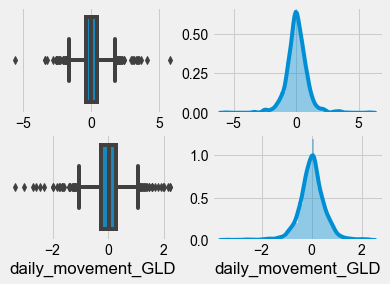

In [13]:
fig,ax = plt.subplots(2,2)

plt.style.use('seaborn-darkgrid')
sns.boxplot(df_slv_vs_gld['daily_movement_SLV'],ax=ax[0,0])
sns.distplot(df_slv_vs_gld['daily_movement_SLV'],ax=ax[0,1])
sns.boxplot(df_slv_vs_gld['daily_movement_GLD'],ax=ax[1,0])
sns.distplot(df_slv_vs_gld['daily_movement_GLD'],ax=ax[1,1]);

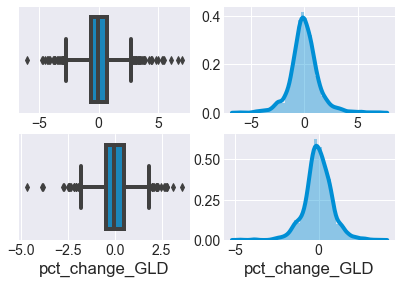

In [14]:
fig,ax = plt.subplots(2,2)

plt.style.use('seaborn-darkgrid')
sns.boxplot(df_slv_vs_gld['pct_change_SLV'],ax=ax[0,0])
sns.distplot(df_slv_vs_gld['pct_change_SLV'],ax=ax[0,1])
sns.boxplot(df_slv_vs_gld['pct_change_GLD'],ax=ax[1,0])
sns.distplot(df_slv_vs_gld['pct_change_GLD'],ax=ax[1,1]);

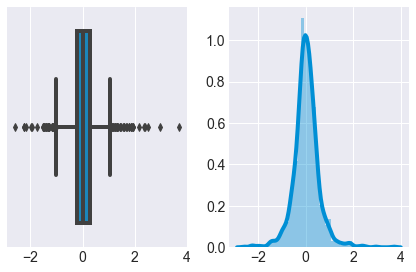

In [15]:
#Testing normality on difference 
day_movement_diff = df_slv_vs_gld['daily_movement_SLV'] - df_slv_vs_gld['daily_movement_GLD']

fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(day_movement_diff,ax=ax[0])
sns.distplot(day_movement_diff,ax=ax[1]);

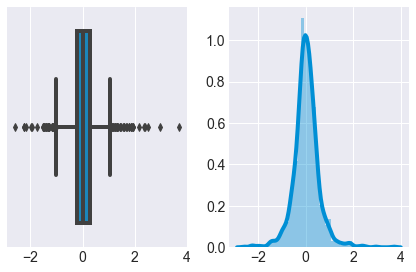

In [16]:
#Testing normality on difference 
pct_change_diff = df_slv_vs_gld['pct_change_SLV'] - df_slv_vs_gld['pct_change_GLD']

fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(day_movement_diff,ax=ax[0])
sns.distplot(day_movement_diff,ax=ax[1]);

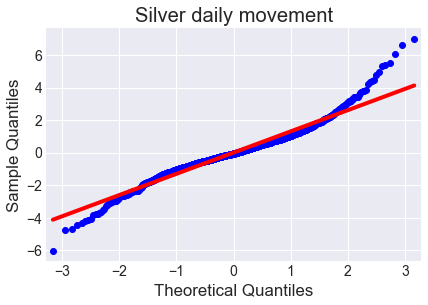

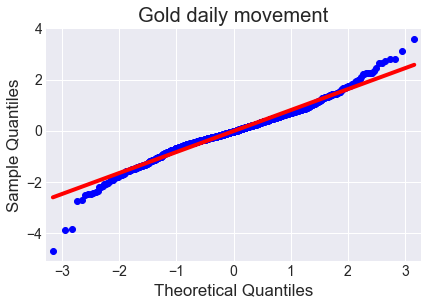

In [17]:

# fig,ax = plt.subplots(2,1)
ax[0] = sm.qqplot(df_slv_vs_gld['pct_change_SLV'], line = 'r')
plt.title('Silver daily movement')

ax[1] = sm.qqplot(df_slv_vs_gld['pct_change_GLD'], line = 'r')
plt.title('Gold daily movement')

plt.show();

In [18]:
#Remove outliers including only data with z value < 3
data = df_slv_vs_gld[(np.abs(stats.zscore(df_slv_vs_gld[['daily_movement_SLV','daily_movement_GLD','delta','delta2']])) < 3).all(axis=1)]
data.head()

,date,symbol_SLV,open_SLV,close_SLV,daily_movement_SLV,scale_SLV,pct_change_SLV,symbol_GLD,open_GLD,close_GLD,daily_movement_GLD,scale_GLD,pct_change_GLD,delta,delta2
0,2019-10-08,SLV,16.60,16.61,-0.060241,1.000602,0.000000,GLD,142.03,141.95,0.056326,1.223391,0.000000,-0.116567,0.000000
1,2019-10-07,SLV,16.38,16.30,0.488400,0.981928,-1.866346,GLD,141.16,140.69,0.332956,1.212531,-0.887636,0.155445,-0.978709
2,2019-10-04,SLV,16.30,16.41,-0.674847,0.988554,0.674847,GLD,141.48,141.90,-0.296862,1.222960,0.860047,-0.377985,-0.185200
3,2019-10-03,SLV,16.38,16.43,-0.305250,0.989759,0.121877,GLD,141.36,141.90,-0.382003,1.222960,0.000000,0.076753,0.121877
4,2019-10-02,SLV,16.33,16.43,-0.612370,0.989759,0.000000,GLD,140.79,141.26,-0.333831,1.217444,-0.451022,-0.278539,0.451022


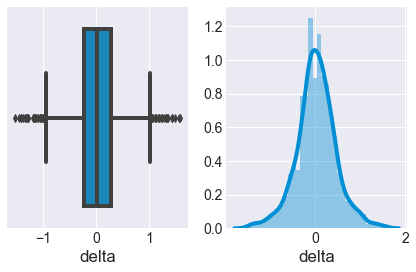

In [19]:
#Testing normality on difference 

fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(data.delta,ax=ax[0])
sns.distplot(data.delta,ax=ax[1]);

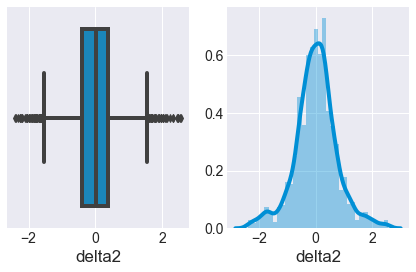

In [20]:
fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(data.delta2,ax=ax[0])
sns.distplot(data.delta2,ax=ax[1]);

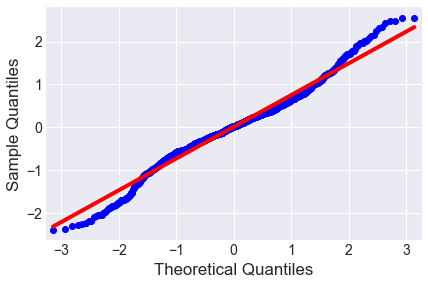

In [21]:
sm.qqplot(data.delta2, line = 'r');

In [22]:
stats.normaltest(data.delta2)

NormaltestResult(statistic=33.30281758915057, pvalue=5.866580638503786e-08)

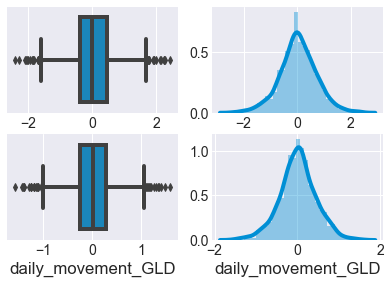

In [23]:
fig,ax = plt.subplots(2,2)

sns.boxplot(data['daily_movement_SLV'],ax=ax[0,0])
sns.distplot(data['daily_movement_SLV'],ax=ax[0,1])
sns.boxplot(data['daily_movement_GLD'],ax=ax[1,0])
sns.distplot(data['daily_movement_GLD'],ax=ax[1,1]);

In [24]:
t,p = stats.ttest_rel(data['daily_movement_SLV'],data['daily_movement_GLD'])
t,p

(1.9077141242682691, 0.05666647797143514)

In [25]:
t,p = stats.ttest_rel(data['pct_change_SLV'],data['pct_change_GLD'])
t,p

(0.46630985404976993, 0.6410782910299906)

In [26]:
x_bar_dy = data.delta.mean()
Sdiff_dy = data.delta.std()
dof = len(data.delta)-1
t_dy = (x_bar_dy - 0)/(Sdiff_dy/np.sqrt(len(data.delta)))

print(f"x_bar:{x_bar_dy}\n sample_std:{Sdiff_dy}\n t-score:{t_dy}")

x_bar:0.0242663718694661
 sample_std:0.4410052781721947
 t-score:1.907714124268269


In [27]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin_dy = x_bar_dy - (tscore * (Sdiff_dy/np.sqrt(len(data.delta))))
rangemax_dy = x_bar_dy + (tscore * (Sdiff_dy/np.sqrt(len(data.delta))))

print(f"confidence interval = {rangemin_dy*100} - {rangemax_dy*100}")

confidence interval = 0.33274685252321323 - 4.520527521370007


## Looking at weekly movement

### $𝐻{0} $ : weekly movement SLV  - weekly movement  GLD = 0 
### $𝐻{a} $ : weekly movement SLV  - weekly movement GLD > 0 


In [28]:
gld_weekly = df_clean_GLD.groupby(['symbol',pd.Grouper(key='date',freq='W')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]
slv_weekly = df_clean_SLV.groupby(['symbol',pd.Grouper(key='date',freq='W')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]

gld_weekly['wk_movement'] = (gld_weekly.open-gld_weekly.close)*100/gld_weekly.open
slv_weekly['wk_movement'] = (slv_weekly.open-slv_weekly.close)*100/slv_weekly.open

gld_weekly['pct_change'] = (gld_weekly.open-gld_weekly.close)*100/gld_weekly.open
slv_weekly['pct_change'] = (slv_weekly.open-slv_weekly.close)*100/slv_weekly.open


df_slv_vs_gld_wk = pd.merge(slv_weekly,
                            gld_weekly,
                            how='left',
                            on='date',
                            suffixes=('_SLV', '_GLD'))

df_slv_vs_gld_wk = df_slv_vs_gld_wk[(np.abs(stats.zscore(df_slv_vs_gld_wk[['wk_movement_SLV','wk_movement_GLD']])) < 3).all(axis=1)]
data.head()

df_slv_vs_gld_wk = df_slv_vs_gld_wk.loc[df_slv_vs_gld_wk.date>'2014-10-06']
print(df_slv_vs_gld_wk.shape)
df_slv_vs_gld_wk.tail()


(261, 9)


,date,open_SLV,close_SLV,wk_movement_SLV,pct_change_SLV,open_GLD,close_GLD,wk_movement_GLD,pct_change_GLD
257,2014-11-09,15.01200,15.084,-0.479616,-0.479616,111.026,111.402,-0.338659,-0.338659
258,2014-11-02,16.16124,16.122,0.242803,0.242803,116.388,116.084,0.261195,0.261195
259,2014-10-26,16.62784,16.600,0.167430,0.167430,119.394,119.206,0.157462,0.157462
260,2014-10-19,16.67012,16.674,-0.023275,-0.023275,118.806,118.862,-0.047136,-0.047136
261,2014-10-12,16.59600,16.604,-0.048204,-0.048204,116.812,117.018,-0.176352,-0.176352


In [29]:
from hypothesis_tests import *

In [30]:
a,b = hypothesis_test_three_prep(df_clean, type = 'day')
hypothesis_test_three_pttest(a,b)

Based on the p value of 0.0192703027039268 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of 0.0494255877745543.


'Reject'

In [31]:
a,b = hypothesis_test_three_prep(df_clean, type = 'week')
hypothesis_test_three_pttest(a,b)

Based on the p value of 0.01671417287879344 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of 0.11459939737524623.


'Reject'

In [32]:
a,b = hypothesis_test_three_prep(df_clean, type = 'month')
hypothesis_test_three_pttest(a,b)

Based on the p value of 0.02568348443109653 and our alpha of 0.05 we reject  the null hypothesis.
Due to these results, we  can state that there is a difference between daily movement of SLV and GLD
with an effect size, cohen's d, of 0.20908498857875527.


'Reject'

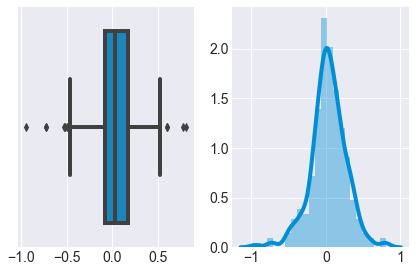

In [33]:
#Testing normality on difference 
wk_movement_diff = df_slv_vs_gld_wk['wk_movement_SLV'] - df_slv_vs_gld_wk['wk_movement_GLD']

fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(wk_movement_diff,ax=ax[0])
sns.distplot(wk_movement_diff,ax=ax[1]);

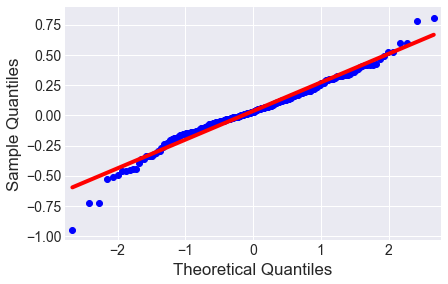

In [34]:
sm.qqplot(wk_movement_diff, line = 'r');

In [35]:
stats.normaltest(wk_movement_diff)

NormaltestResult(statistic=17.779682053032943, pvalue=0.0001377815598551675)

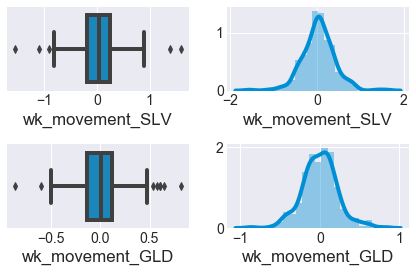

In [36]:
fig,ax = plt.subplots(2,2, tight_layout=True)
sns.boxplot(df_slv_vs_gld_wk['wk_movement_SLV'],ax=ax[0,0])
sns.distplot(df_slv_vs_gld_wk['wk_movement_SLV'],ax=ax[0,1],label='silver')
sns.boxplot(df_slv_vs_gld_wk['wk_movement_GLD'],ax=ax[1,0])
sns.distplot(df_slv_vs_gld_wk['wk_movement_GLD'],ax=ax[1,1],label='gold')
plt.show();

In [37]:
x_bar = wk_movement_diff.mean()
Sdiff = wk_movement_diff.std()
dof = len(wk_movement_diff)-1
t = (x_bar - 0)/(Sdiff/np.sqrt(len(wk_movement_diff)))

print(x_bar,Sdiff,t)

0.03524388654743765 0.23640465644774714 2.4085076032821657


In [38]:
t,p = stats.ttest_rel(df_slv_vs_gld_wk['wk_movement_SLV'],df_slv_vs_gld_wk['wk_movement_GLD'])
t,p

(2.408507603282167, 0.01671417287879344)

In [39]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin = x_bar - (tscore * (Sdiff/np.sqrt(len(wk_movement_diff))))
rangemax = x_bar + (tscore * (Sdiff/np.sqrt(len(wk_movement_diff))))

print(f"confidence interval = {rangemin*100} - {rangemax*100}")

confidence interval = 1.1088542777581174 - 5.939923031729413


In [40]:
spooled_wk = np.sqrt(((df_slv_vs_gld_wk['wk_movement_SLV'].std()**2 + df_slv_vs_gld_wk['wk_movement_GLD'].std()**2)/2))
Cohen_d_wk = (df_slv_vs_gld_wk['wk_movement_SLV'].mean() - df_slv_vs_gld_wk['wk_movement_GLD'].mean()) / spooled_wk
Cohen_d_wk

0.11459939737524623

In [41]:
# import statsmodels.stats.power as smp
# smp.ttest_power(Cohen_d_wk, nobs=len(wk_movement_diff), alpha=0.05, alternative='larger')

In [42]:
def hypothesis_test_three_week(df_clean, alpha = 0.05):
    gld_weekly = df_clean_GLD.groupby(['symbol',pd.Grouper(key='date',freq='W')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]
    slv_weekly = df_clean_SLV.groupby(['symbol',pd.Grouper(key='date',freq='W')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]

    gld_weekly['wk_movement'] = (gld_weekly.open-gld_weekly.close)*100/gld_weekly.open
    slv_weekly['wk_movement'] = (slv_weekly.open-slv_weekly.close)*100/slv_weekly.open

    df_slv_vs_gld_wk = pd.merge(slv_weekly,
                                gld_weekly,
                                how='left',
                                on='date',
                                suffixes=('_SLV', '_GLD'))

    df_slv_vs_gld_wk = df_slv_vs_gld_wk[(np.abs(stats.zscore(df_slv_vs_gld_wk[['wk_movement_SLV','wk_movement_GLD']])) < 3).all(axis=1)]
    df_slv_vs_gld_wk = df_slv_vs_gld_wk.loc[df_slv_vs_gld_wk.date>'2014-10-06']
    
    t_val,p_val = stats.ttest_rel(df_slv_vs_gld_wk['wk_movement_SLV'],df_slv_vs_gld_wk['wk_movement_GLD'])

    status = compare_pval_alpha(p_val, alpha)
    assertion = ''
    if status == 'Fail to reject':
        assertion = 'cannot'
    else:
        assertion = "can"
    
    spooled_wk = np.sqrt(((df_slv_vs_gld_wk['wk_movement_SLV'].std()**2 + df_slv_vs_gld_wk['wk_movement_GLD'].std()**2)/2))
    coh_d = (df_slv_vs_gld_wk['wk_movement_SLV'].mean() - df_slv_vs_gld_wk['wk_movement_GLD'].mean()) / spooled_mo

    print(f'Based on the p value of {round(p_val,2)} and our aplha of {alpha} we {status.lower()}  the null hypothesis.'
          f'\nDue to these results, we  {assertion} state that there is a difference between weekly movement of SLV and GLD')

    if assertion == 'can':
        print(f"with an effect size, cohen's d, of {round(coh_d,2)}.")
    else:
        print(".")

    return status

hypothesis_test_three_week(df_clean, alpha = 0.05)


NameError: name 'spooled_mo' is not defined

## Looking at monthly movement

### $𝐻{0} $ : monthly movement SLV  - monthly movement  GLD = 0 
### $𝐻{a} $ : monthly movement SLV  - monthly movement GLD > 0 


In [ ]:
gld_monthly = df_clean_GLD.groupby(['symbol',pd.Grouper(key='date',freq='M')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]
slv_monthly = df_clean_SLV.groupby(['symbol',pd.Grouper(key='date',freq='M')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]

gld_monthly['mo_movement'] = (gld_monthly.open-gld_monthly.close)*100/gld_monthly.open
slv_monthly['mo_movement'] = (slv_monthly.open-slv_monthly.close)*100/slv_monthly.open

df_slv_vs_gld_mo = pd.merge(slv_monthly,
                            gld_monthly,
                            how='left',
                            on='date',
                            suffixes=('_SLV', '_GLD'))

df_slv_vs_gld_mo = df_slv_vs_gld_mo[(np.abs(stats.zscore(df_slv_vs_gld_mo[['mo_movement_SLV','mo_movement_GLD']])) < 3).all(axis=1)]

df_slv_vs_gld_mo = df_slv_vs_gld_mo.loc[df_slv_vs_gld_mo.date>'2014-10-06']
print(df_slv_vs_gld_mo.shape)


In [ ]:
#Testing normality on difference 
mo_movement_diff = df_slv_vs_gld_mo['mo_movement_SLV'] - df_slv_vs_gld_mo['mo_movement_GLD']

fig,ax = plt.subplots(1,2, tight_layout=True)
sns.boxplot(mo_movement_diff,ax=ax[0])
sns.distplot(mo_movement_diff,ax=ax[1]);

In [ ]:
sm.qqplot(mo_movement_diff, line = 'r');

In [ ]:
stats.normaltest(mo_movement_diff)

In [ ]:
fig,ax = plt.subplots(2,2, tight_layout=True)

sns.boxplot(df_slv_vs_gld_mo['mo_movement_SLV'],ax=ax[0,0])
sns.distplot(df_slv_vs_gld_mo['mo_movement_SLV'],ax=ax[0,1])
sns.boxplot(df_slv_vs_gld_mo['mo_movement_GLD'],ax=ax[1,0])
sns.distplot(df_slv_vs_gld_mo['mo_movement_GLD'],ax=ax[1,1]);

In [ ]:
t,p = stats.ttest_rel(df_slv_vs_gld_mo['mo_movement_SLV'],df_slv_vs_gld_mo['mo_movement_GLD'])
t,p

In [ ]:
x_bar_mo = mo_movement_diff.mean()
Sdiff_mo = mo_movement_diff.std()
dof_mo = len(mo_movement_diff)-1
t_mo = (x_bar_mo - 0)/(Sdiff_mo/np.sqrt(len(mo_movement_diff)))

print(x_bar_mo,Sdiff_mo,t_mo)

In [ ]:
tscore = (stats.t.ppf(1-0.05, dof))
rangemin_mo = x_bar_mo - (tscore * (Sdiff_mo/np.sqrt(len(mo_movement_diff))))
rangemax_mo = x_bar_mo + (tscore * (Sdiff_mo/np.sqrt(len(mo_movement_diff))))

print(f"confidence interval = {round(rangemin_mo,2)} - {round(rangemax_mo,2)}")

In [ ]:
spooled_mo = np.sqrt(((df_slv_vs_gld_mo['mo_movement_SLV'].std()**2 + df_slv_vs_gld_mo['mo_movement_GLD'].std()**2)/2))
Cohen_d_mo = (df_slv_vs_gld_mo['mo_movement_SLV'].mean() - df_slv_vs_gld_mo['mo_movement_GLD'].mean()) / spooled_mo
round(Cohen_d_mo,2)

In [ ]:
def hypothesis_test_three_month(df_clean, alpha = 0.05):
    
    #Creating dataset for paired t-test
    df_clean_SLV = df_clean.loc[df_clean['symbol'] == 'SLV']
    df_clean_GLD = df_clean.loc[df_clean['symbol'] == 'GLD']
    
    gld_monthly = df_clean_GLD.groupby(['symbol',pd.Grouper(key='date',freq='M')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]
    slv_monthly = df_clean_SLV.groupby(['symbol',pd.Grouper(key='date',freq='M')]).mean().reset_index().sort_values('date',ascending=False)[['date','open','close']]

    gld_monthly['mo_movement'] = (gld_monthly.open-gld_monthly.close)*100/gld_monthly.open
    slv_monthly['mo_movement'] = (slv_monthly.open-slv_monthly.close)*100/slv_monthly.open

    df_slv_vs_gld_mo = pd.merge(slv_monthly,
                            gld_monthly,
                            how='left',
                            on='date',
                            suffixes=('_SLV', '_GLD'))

    df_slv_vs_gld_mo = df_slv_vs_gld_mo[(np.abs(stats.zscore(df_slv_vs_gld_mo[['mo_movement_SLV','mo_movement_GLD']])) < 3).all(axis=1)]
    df_slv_vs_gld_mo = df_slv_vs_gld_mo.loc[df_slv_vs_gld_mo.date>'2014-10-06']

    #Perform paired ttest
    t_val,p_val = stats.ttest_rel(df_slv_vs_gld_mo['mo_movement_SLV'],df_slv_vs_gld_mo['mo_movement_GLD'])
    spooled_mo = np.sqrt(((df_slv_vs_gld_mo['mo_movement_SLV'].std()**2 + df_slv_vs_gld_mo['mo_movement_GLD'].std()**2)/2))
    coh_d = (df_slv_vs_gld_mo['mo_movement_SLV'].mean() - df_slv_vs_gld_mo['mo_movement_GLD'].mean()) / spooled_mo

    #Conclusion
    status = compare_pval_alpha(p_val, alpha)
    assertion = ''
    if status == 'Fail to reject':
        assertion = 'cannot'
    else:
        assertion = "can"
    
    print(f'Based on the p value of {round(p_val,2)} and our aplha of {alpha} we {status.lower()}  the null hypothesis.'
          f'\nDue to these results, we  {assertion} state that there is a difference between monthly movement of SLV and GLD')

    if assertion == 'can':
        print(f"with an effect size, Cohen's d, of {round(coh_d,2)}.")
    else:
        print(".")

    return status
    

In [ ]:
hypothesis_test_three_week(df_clean, alpha = 0.05)

In [ ]:
from statsmodels.stats.power import  tt_solve_power

In [ ]:
tt_solve_power(effect_size=Cohen_d_mo, nobs=len(mo_movement_diff), alpha=.05,power=None,alternative='larger')


In [ ]:
from hypothesis_tests import hypothesis_test_three_prep